In [157]:
import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras import layers
from keras.layers import Conv1D, GRU, Dense, BatchNormalization, Dropout, MaxPool1D,Activation, regularizers
from keras import Sequential
from keras.preprocessing import text
from keras.layers import regularizers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import scipy.io.wavfile as wav

from sklearn.preprocessing import LabelEncoder

import shutil
import os
from pathlib import Path 
import re
from collections import OrderedDict

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction as aF


from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

In [158]:
path_data = Path('../data/')
os.listdir(path_data)

['ComParE2018_AtypicalAffect.txt',
 'readme.docx',
 'Schuller_SpeechAnalysis.pdf',
 'spectogram',
 'wav']

In [159]:
df_labs = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep='\t')

def getData(file):
    [fs,x]  = audioBasicIO.readAudioFile(path_data/'wav'/file)
    x = np.resize(x,(fs*4,))
    [s,t] = aF.stFeatureExtraction(x,fs,0.050*fs,0.025*fs)
    s = s.T
    return s

def fetch_data(directory='wav/', subset='train'):
    sub = df_labs['file_name'].apply(lambda fn: subset in fn)
    df_lab_sub = df_labs[sub]
    y = df_lab_sub['emotion'].values
    fn = df_lab_sub['file_name']

    X = OrderedDict()
    for f in fn:
        X[f] = getData(f)
        
    return X.values(), y

In [160]:
(tr_X, tr_y) = fetch_data(directory=path_data/'wav', subset='train')
(dv_X, dv_y) = fetch_data(directory=path_data/'wav', subset='devel')
(test_X, test_y) = fetch_data(directory=path_data/'wav', subset='test')

In [161]:
tr_X = np.asarray(list(tr_X))
dv_X = np.asarray(list(dv_X))
test_X = np.asarray(list(test_X))

In [83]:
# DATA_TRAIN = tr_X
# DATA_dev = dv_X
# DATA_test = test_X

#FOR TESTING PURPOSE

In [ ]:
# def normalize_data(tr_X, val_X = None, ts_X=None):
#     m = tr_X.mean(axis=1)
#     sd = tr_X.std(axis=1)
#     return m,sd,(tr_X-m)/sd #, (val_X-m)/sd, (ts_X-m)/sd, 

# tr_mean,tr_sd,tr_X = normalize_data(tr_X)
# dv_X = (dv_X-tr_mean)/tr_sd
# test_X = (test_X-tr_mean)/tr_sd
#PREVIOUS NORMALIZING

In [162]:
m = np.mean(tr_X.mean(axis=1),axis=0)
std = np.mean(tr_X.std(axis=1),axis=0)

def normalize(mat):
    global m
    global std
    print(np.shape(mat))
    m_temp = np.reshape(m,(1,34))
    std_temp = np.reshape(std,(1,34))
    
    mat = (mat - m_temp)/std_temp
    return mat

In [ ]:
for i in range(np.shape(tr_X)[0]):
    tr_X[i] = normalize(tr_X[i])
    
for i in range(np.shape(dv_X)[0]):
    dv_X[i] = normalize(dv_X[i])
    
for i in range(np.shape(test_X)[0]):
    test_X[i] = normalize(test_X[i]) 

In [164]:
le = LabelEncoder()
tr_y = le.fit_transform(tr_y)
dv_y = le.fit_transform(dv_y)
test_y = le.fit_transform(test_y)

In [165]:
from collections import Counter
c = Counter(tr_y)
len(tr_y)/np.asarray(list(c.values())) #class weights based on number of samples

array([ 1.46130302,  4.49798116, 17.87165775, 26.736     ])

In [166]:
class_weight = {0: 23.736,
                1: 4.49798116,
                2: 1.46130302,
                3: 17.87165775}

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [247]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=10, activation='relu', input_shape=(np.shape(tr_X)[1], np.shape(tr_X)[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(layers.Flatten())
model.add(Dense(4, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=RMSprop(lr=.0001), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 150, 15)           5115      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 15)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 69, 32)            3392      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 32)            5152      
__________

In [248]:
model.fit(tr_X, tr_y, epochs=100,validation_data=(dv_X, dv_y),class_weight=class_weight, callbacks=[es])

Train on 3342 samples, validate on 3000 samples
Epoch 1/100
3342/3342 [==============================] - 3s 1ms/step - loss: 5.5386 - acc: 0.1565 - val_loss: 1.4653 - val_acc: 0.2137
Epoch 2/100
3342/3342 [==============================] - 3s 748us/step - loss: 5.3559 - acc: 0.1954 - val_loss: 1.4235 - val_acc: 0.1983
Epoch 3/100
3342/3342 [==============================] - 3s 773us/step - loss: 5.1992 - acc: 0.2178 - val_loss: 1.3873 - val_acc: 0.1580
Epoch 4/100
3342/3342 [==============================] - 3s 757us/step - loss: 5.0678 - acc: 0.2334 - val_loss: 1.4111 - val_acc: 0.1530
Epoch 5/100
3342/3342 [==============================] - 2s 708us/step - loss: 4.9585 - acc: 0.2343 - val_loss: 1.4363 - val_acc: 0.1353
Epoch 6/100
3342/3342 [==============================] - 3s 768us/step - loss: 4.8925 - acc: 0.2139 - val_loss: 1.4278 - val_acc: 0.1387
Epoch 7/100
3342/3342 [==============================] - 3s 785us/step - loss: 4.8034 - acc: 0.2606 - val_loss: 1.4294 - val_acc: 0.

In [249]:
y_pred = model.predict(dv_X)
y_pred = y_pred.argmax(axis = 1)

In [254]:
from keras.models import load_model

model.save('1DCNNModel.h5')

In [250]:
def reporting(y_test,y_pred):
    confusion_matrix = ConfusionMatrix(y_test, y_pred)
    confusion_matrix.plot()
    plt.show()
    print(confusion_matrix)
    print("\n",classification_report(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))

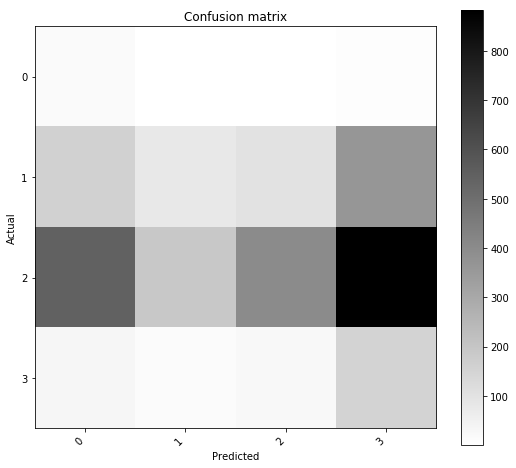

Predicted    0    1    2     3  __all__
Actual                                 
0           20    4    1     8       33
1          160   82  103   364      709
2          546  193  402   883     2024
3           35   18   28   153      234
__all__    761  297  534  1408     3000

               precision    recall  f1-score   support

           0       0.03      0.61      0.05        33
           1       0.28      0.12      0.16       709
           2       0.75      0.20      0.31      2024
           3       0.11      0.65      0.19       234

   micro avg       0.22      0.22      0.22      3000
   macro avg       0.29      0.39      0.18      3000
weighted avg       0.58      0.22      0.27      3000

0.219


In [251]:
reporting(dv_y,y_pred) #on validation set

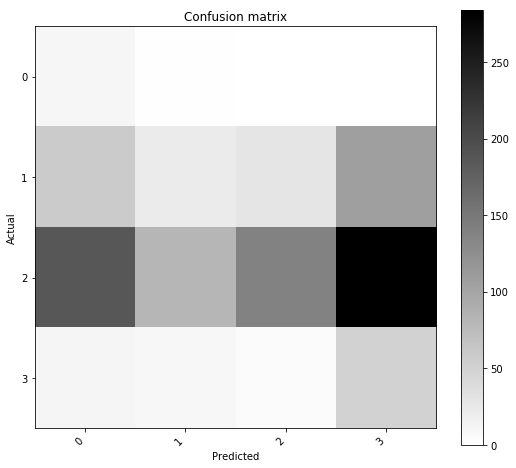

Predicted    0    1    2    3  __all__
Actual                                
0           11    2    0    1       14
1           58   23   29  107      217
2          187   81  139  284      691
3           12    9    5   51       77
__all__    268  115  173  443      999

               precision    recall  f1-score   support

           0       0.04      0.79      0.08        14
           1       0.20      0.11      0.14       217
           2       0.80      0.20      0.32       691
           3       0.12      0.66      0.20        77

   micro avg       0.22      0.22      0.22       999
   macro avg       0.29      0.44      0.18       999
weighted avg       0.61      0.22      0.27       999

0.22422422422422422


In [252]:
#test prediction 
y_pred_t = model.predict(test_X)
y_pred_t = y_pred_t.argmax(axis = 1)
reporting(test_y,y_pred_t)